# Notebook 02 : Feature Engineering
## Sélection et Réduction de Dimensionnalité


### Algorithmes implémentés :
| # | Méthode | Type | Description |
|---|---------|------|-------------|
| 1 | **RFE** | Sélection | Recursive Feature Elimination |
| 2 | **SBS** | Sélection | Sequential Backward Selection |
| 3 | **LASSO** | Sélection | Régularisation L1 |
| 4 | **PCA** | Réduction | Principal Component Analysis |
| 5 | **LDA** | Réduction | Linear Discriminant Analysis |
| 6 | **t-SNE** | Réduction | t-Distributed Stochastic Neighbor Embedding |


## 1. Configuration et Imports

In [12]:
# ============================================================================
# CONFIGURATION ET IMPORTS
# ============================================================================

# Librairies de base
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import time
from datetime import datetime

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn - Prétraitement
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Scikit-learn - Feature Selection
from sklearn.feature_selection import RFE, SelectFromModel, SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression, LassoCV, Lasso

# Scikit-learn - Dimensionality Reduction
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE

# Scikit-learn - Modèles pour évaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# MLflow
import mlflow
import mlflow.sklearn

# Configuration de l'affichage
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Style des graphiques
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Couleurs personnalisées
COLORS = {
    'primary': '#2E86AB',
    'secondary': '#A23B72',
    'success': '#28A745',
    'danger': '#DC3545',
    'warning': '#FFC107',
    'info': '#17A2B8',
    'healthy': '#28A745',
    'disease': '#DC3545',
    'rfe': '#E74C3C',
    'sbs': '#3498DB',
    'lasso': '#2ECC71',
    'pca': '#9B59B6',
    'lda': '#F39C12',
    'tsne': '#1ABC9C'
}

# Seed pour reproductibilité
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Configuration terminée avec succès !")
print(f"Date d'exécution : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Configuration terminée avec succès !
Date d'exécution : 2026-02-13 17:38:39


## 2. Configuration MLflow

In [13]:
# ============================================================================
# CONFIGURATION MLFLOW
# ============================================================================

# Définir le répertoire de tracking MLflow
mlflow.set_tracking_uri("file:./mlruns")

# Créer ou récupérer l'expérience
EXPERIMENT_NAME = "Heart_Disease_Feature_Engineering"

# Vérifier si l'expérience existe
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if experiment is None:
    experiment_id = mlflow.create_experiment(
        EXPERIMENT_NAME,
        tags={"project": "Heart Disease Prediction", "phase": "Feature Engineering"}
    )
    print(f"Expérience créée : {EXPERIMENT_NAME} (ID: {experiment_id})")
else:
    experiment_id = experiment.experiment_id
    print(f"Expérience existante : {EXPERIMENT_NAME} (ID: {experiment_id})")

mlflow.set_experiment(EXPERIMENT_NAME)

print("\nMLflow configuré avec succès !")
print(f"Tracking URI : {mlflow.get_tracking_uri()}")
print("\nPour lancer l'interface MLflow :")
print(">>> mlflow ui --port 5000")

Expérience existante : Heart_Disease_Feature_Engineering (ID: 444656991134449736)

MLflow configuré avec succès !
Tracking URI : file:./mlruns

Pour lancer l'interface MLflow :
>>> mlflow ui --port 5000


## 3. Chargement et Préparation des Données

In [14]:
# ============================================================================
# CHARGEMENT DES DONNÉES
# ============================================================================

# Charger le dataset
df = pd.read_csv('heart.csv')

print("Dataset chargé avec succès !")
print(f"Dimensions : {df.shape[0]} lignes x {df.shape[1]} colonnes")
print(f"\nVariables : {list(df.columns)}")

Dataset chargé avec succès !
Dimensions : 1025 lignes x 14 colonnes

Variables : ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']


In [15]:
# ============================================================================
# SÉPARATION FEATURES / TARGET
# ============================================================================

# Séparer les features et la cible
X = df.drop('target', axis=1)
y = df['target']

# Noms des features
feature_names = X.columns.tolist()

print(f"Features (X) : {X.shape}")
print(f"Target (y) : {y.shape}")
print(f"\nNoms des features : {feature_names}")
print(f"\nDistribution de la cible :")
print(y.value_counts())

Features (X) : (1025, 13)
Target (y) : (1025,)

Noms des features : ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']

Distribution de la cible :
target
1    526
0    499
Name: count, dtype: int64


In [16]:
# ============================================================================
# DIVISION TRAIN/TEST
# ============================================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE,
    stratify=y
)

print("Division Train/Test effectuée :")
print(f"  - Train : {X_train.shape[0]} échantillons ({X_train.shape[0]/len(X)*100:.0f}%)")
print(f"  - Test  : {X_test.shape[0]} échantillons ({X_test.shape[0]/len(X)*100:.0f}%)")

Division Train/Test effectuée :
  - Train : 820 échantillons (80%)
  - Test  : 205 échantillons (20%)


In [17]:
# ============================================================================
# STANDARDISATION DES DONNÉES
# ============================================================================

# Standardisation (essentielle pour PCA, LDA, t-SNE)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertir en DataFrame pour faciliter l'utilisation
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_names, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_names, index=X_test.index)

print("Données standardisées avec StandardScaler")
print(f"\nMoyenne après standardisation : {X_train_scaled.mean(axis=0).round(6)}")
print(f"Écart-type après standardisation : {X_train_scaled.std(axis=0).round(2)}")

Données standardisées avec StandardScaler

Moyenne après standardisation : [-0.  0.  0.  0. -0. -0. -0.  0. -0.  0. -0.  0. -0.]
Écart-type après standardisation : [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


## 4. Fonction Utilitaire pour l'Évaluation

In [18]:
# ============================================================================
# FONCTION D'ÉVALUATION
# ============================================================================

def evaluate_features(X_train_feat, X_test_feat, y_train, y_test, method_name):
    """
    Évalue la qualité des features sélectionnées/réduites
    en entraînant un RandomForest et en calculant l'accuracy.
    
    Parameters:
    -----------
    X_train_feat : array-like - Features d'entraînement
    X_test_feat : array-like - Features de test
    y_train : array-like - Labels d'entraînement
    y_test : array-like - Labels de test
    method_name : str - Nom de la méthode
    
    Returns:
    --------
    dict : Dictionnaire contenant les métriques
    """
    # Modèle d'évaluation
    model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
    
    # Entraînement
    start_time = time.time()
    model.fit(X_train_feat, y_train)
    train_time = time.time() - start_time
    
    # Prédictions
    y_pred_train = model.predict(X_train_feat)
    y_pred_test = model.predict(X_test_feat)
    
    # Métriques
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_feat, y_train, cv=5, scoring='accuracy')
    
    results = {
        'method': method_name,
        'n_features': X_train_feat.shape[1],
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'train_time': train_time
    }
    
    return results, model

print("Fonction d'évaluation définie.")

Fonction d'évaluation définie.


In [19]:
# ============================================================================
# STOCKAGE DES RÉSULTATS
# ============================================================================

# Dictionnaire pour stocker tous les résultats
all_results = []
selected_features_dict = {}
transformed_data_dict = {}

print("Structures de stockage initialisées.")

Structures de stockage initialisées.


---

## 5. Méthode 1 : RFE (Recursive Feature Elimination)

**Principe :** RFE entraîne un modèle de manière récursive et élimine les features les moins importantes à chaque itération.

In [20]:
# ============================================================================
# RFE - RECURSIVE FEATURE ELIMINATION
# ============================================================================

print("="*80)
print("MÉTHODE 1 : RFE (Recursive Feature Elimination)")
print("="*80)

# Démarrer le run MLflow
with mlflow.start_run(run_name="RFE_Selection"):
    
    start_time = time.time()
    
    # Paramètres
    n_features_to_select = 7  # Sélectionner la moitié des features
    
    # Modèle de base pour RFE
    base_model = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
    
    # Appliquer RFE
    rfe = RFE(
        estimator=base_model,
        n_features_to_select=n_features_to_select,
        step=1,
        verbose=0
    )
    
    rfe.fit(X_train_scaled, y_train)
    
    execution_time = time.time() - start_time
    
    # Features sélectionnées
    selected_mask = rfe.support_
    selected_features_rfe = [f for f, s in zip(feature_names, selected_mask) if s]
    feature_ranking = rfe.ranking_
    
    # Transformer les données
    X_train_rfe = rfe.transform(X_train_scaled)
    X_test_rfe = rfe.transform(X_test_scaled)
    
    # Évaluer
    results, _ = evaluate_features(X_train_rfe, X_test_rfe, y_train, y_test, "RFE")
    
    # Logger dans MLflow
    mlflow.log_param("method", "RFE")
    mlflow.log_param("base_estimator", "LogisticRegression")
    mlflow.log_param("n_features_to_select", n_features_to_select)
    mlflow.log_param("n_original_features", len(feature_names))
    mlflow.log_param("selected_features", selected_features_rfe)
    
    mlflow.log_metric("n_selected_features", len(selected_features_rfe))
    mlflow.log_metric("train_accuracy", results['train_accuracy'])
    mlflow.log_metric("test_accuracy", results['test_accuracy'])
    mlflow.log_metric("cv_mean_accuracy", results['cv_mean'])
    mlflow.log_metric("cv_std_accuracy", results['cv_std'])
    mlflow.log_metric("execution_time", execution_time)
    
    # Tags
    mlflow.set_tag("feature_selection_type", "wrapper")
    mlflow.set_tag("algorithm", "RFE")
    
    # Sauvegarder
    all_results.append(results)
    selected_features_dict['RFE'] = selected_features_rfe
    transformed_data_dict['RFE'] = {'train': X_train_rfe, 'test': X_test_rfe}
    
    print(f"\n\u2705 RFE terminé en {execution_time:.2f}s")
    print(f"\nFeatures sélectionnées ({len(selected_features_rfe)}/{len(feature_names)}) :")
    print(f"  {selected_features_rfe}")
    print(f"\nRanking des features :")
    ranking_df = pd.DataFrame({
        'Feature': feature_names,
        'Ranking': feature_ranking,
        'Selected': selected_mask
    }).sort_values('Ranking')
    display(ranking_df)

MÉTHODE 1 : RFE (Recursive Feature Elimination)

✅ RFE terminé en 0.02s

Features sélectionnées (7/13) :
  ['sex', 'cp', 'thalach', 'exang', 'oldpeak', 'ca', 'thal']

Ranking des features :


,Feature,Ranking,Selected
1,sex,1,True
2,cp,1,True
7,thalach,1,True
8,exang,1,True
12,thal,1,True
11,ca,1,True
9,oldpeak,1,True
3,trestbps,2,False
10,slope,3,False
4,chol,4,False


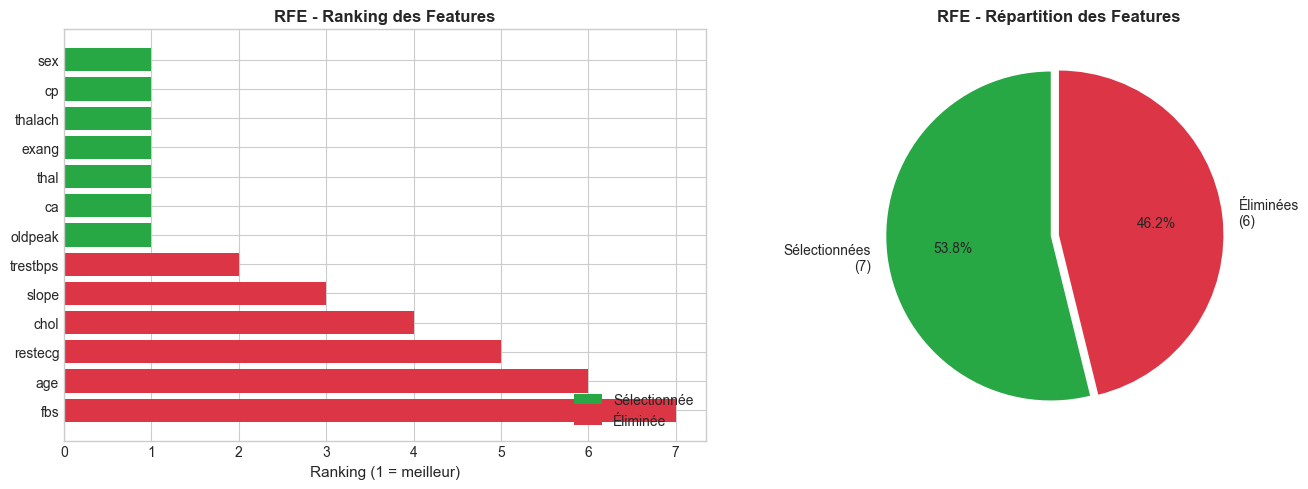

Figure sauvegardée : rfe_results.png


In [21]:
# ============================================================================
# VISUALISATION RFE
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Ranking des features
ax1 = axes[0]
colors_rfe = [COLORS['success'] if s else COLORS['danger'] for s in selected_mask]
ranking_sorted = ranking_df.sort_values('Ranking')
bars = ax1.barh(ranking_sorted['Feature'], ranking_sorted['Ranking'], 
                color=[COLORS['success'] if s else COLORS['danger'] for s in ranking_sorted['Selected']])
ax1.set_xlabel('Ranking (1 = meilleur)', fontsize=11)
ax1.set_title('RFE - Ranking des Features', fontsize=12, fontweight='bold')
ax1.invert_yaxis()

# Légende
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=COLORS['success'], label='Sélectionnée'),
                   Patch(facecolor=COLORS['danger'], label='Éliminée')]
ax1.legend(handles=legend_elements, loc='lower right')

# 2. Features sélectionnées vs éliminées
ax2 = axes[1]
selected_count = sum(selected_mask)
eliminated_count = len(selected_mask) - selected_count
ax2.pie([selected_count, eliminated_count], 
        labels=[f'Sélectionnées\n({selected_count})', f'Éliminées\n({eliminated_count})'],
        colors=[COLORS['success'], COLORS['danger']],
        autopct='%1.1f%%', startangle=90, explode=(0.05, 0))
ax2.set_title('RFE - Répartition des Features', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('images/rfe_results.png', dpi=300, bbox_inches='tight')
plt.show()

# Logger l'artefact
with mlflow.start_run(run_name="RFE_Selection", nested=True):
    mlflow.log_artifact('images/rfe_results.png')

print("Figure sauvegardée : rfe_results.png")

---

## 6. Méthode 2 : Sequential Backward Selection (SBS)

**Principe :** SBS commence avec toutes les features et les élimine une par une en gardant celles qui maximisent la performance.

In [22]:
# ============================================================================
# SBS - SEQUENTIAL BACKWARD SELECTION
# ============================================================================

print("="*80)
print("MÉTHODE 2 : Sequential Backward Selection (SBS)")
print("="*80)

with mlflow.start_run(run_name="SBS_Selection"):
    
    start_time = time.time()
    
    # Paramètres
    n_features_to_select = 7
    
    # Modèle de base
    base_model = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
    
    # Appliquer SBS (direction='backward')
    sbs = SequentialFeatureSelector(
        estimator=base_model,
        n_features_to_select=n_features_to_select,
        direction='backward',
        scoring='accuracy',
        cv=5,
        n_jobs=-1
    )
    
    sbs.fit(X_train_scaled, y_train)
    
    execution_time = time.time() - start_time
    
    # Features sélectionnées
    selected_mask_sbs = sbs.get_support()
    selected_features_sbs = [f for f, s in zip(feature_names, selected_mask_sbs) if s]
    
    # Transformer les données
    X_train_sbs = sbs.transform(X_train_scaled)
    X_test_sbs = sbs.transform(X_test_scaled)
    
    # Évaluer
    results, _ = evaluate_features(X_train_sbs, X_test_sbs, y_train, y_test, "SBS")
    
    # Logger dans MLflow
    mlflow.log_param("method", "SBS")
    mlflow.log_param("direction", "backward")
    mlflow.log_param("base_estimator", "LogisticRegression")
    mlflow.log_param("n_features_to_select", n_features_to_select)
    mlflow.log_param("cv_folds", 5)
    mlflow.log_param("selected_features", selected_features_sbs)
    
    mlflow.log_metric("n_selected_features", len(selected_features_sbs))
    mlflow.log_metric("train_accuracy", results['train_accuracy'])
    mlflow.log_metric("test_accuracy", results['test_accuracy'])
    mlflow.log_metric("cv_mean_accuracy", results['cv_mean'])
    mlflow.log_metric("cv_std_accuracy", results['cv_std'])
    mlflow.log_metric("execution_time", execution_time)
    
    mlflow.set_tag("feature_selection_type", "wrapper")
    mlflow.set_tag("algorithm", "SBS")
    
    # Sauvegarder
    all_results.append(results)
    selected_features_dict['SBS'] = selected_features_sbs
    transformed_data_dict['SBS'] = {'train': X_train_sbs, 'test': X_test_sbs}
    
    print(f"\n\u2705 SBS terminé en {execution_time:.2f}s")
    print(f"\nFeatures sélectionnées ({len(selected_features_sbs)}/{len(feature_names)}) :")
    print(f"  {selected_features_sbs}")

MÉTHODE 2 : Sequential Backward Selection (SBS)

✅ SBS terminé en 17.06s

Features sélectionnées (7/13) :
  ['sex', 'cp', 'restecg', 'oldpeak', 'slope', 'ca', 'thal']


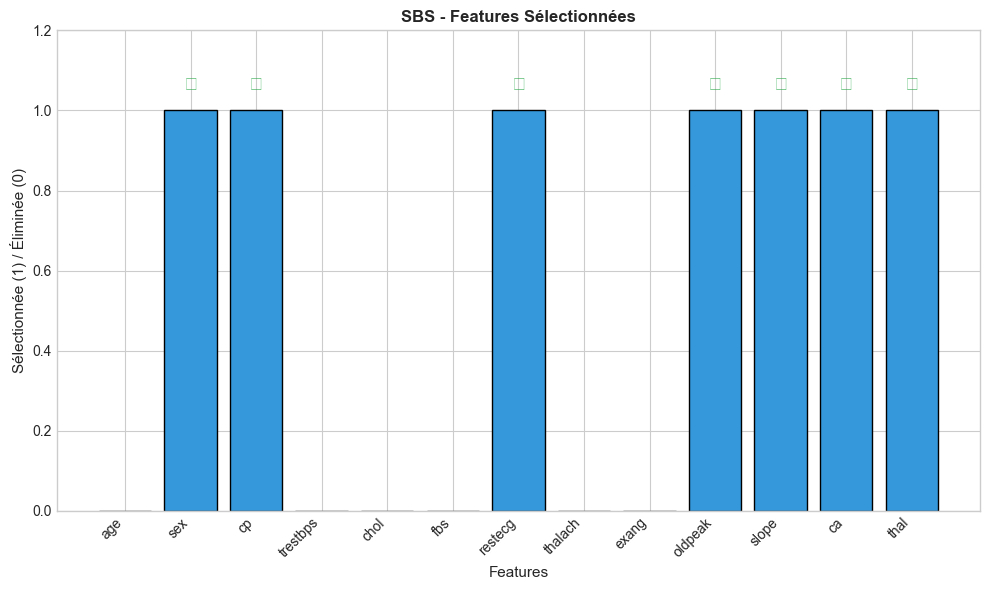

Figure sauvegardée : sbs_results.png


In [23]:
# ============================================================================
# VISUALISATION SBS
# ============================================================================

fig, ax = plt.subplots(figsize=(10, 6))

# Bar plot des features
colors_sbs = [COLORS['sbs'] if s else '#CCCCCC' for s in selected_mask_sbs]
bars = ax.bar(feature_names, selected_mask_sbs.astype(int), color=colors_sbs, edgecolor='black')

# Personnalisation
ax.set_ylabel('Sélectionnée (1) / Éliminée (0)', fontsize=11)
ax.set_xlabel('Features', fontsize=11)
ax.set_title('SBS - Features Sélectionnées', fontsize=12, fontweight='bold')
ax.set_xticklabels(feature_names, rotation=45, ha='right')
ax.set_ylim(0, 1.2)

# Annoter
for i, (bar, selected) in enumerate(zip(bars, selected_mask_sbs)):
    if selected:
        ax.text(bar.get_x() + bar.get_width()/2, 1.05, '\u2713', 
                ha='center', fontsize=14, color=COLORS['success'])

plt.tight_layout()
plt.savefig('images/sbs_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure sauvegardée : sbs_results.png")

---

## 7. Méthode 3 : LASSO (L1 Regularization)

**Principe :** LASSO utilise la régularisation L1 pour réduire certains coefficients à zéro, effectuant ainsi une sélection automatique.

In [24]:
# ============================================================================
# LASSO - SÉLECTION PAR RÉGULARISATION L1
# ============================================================================

print("="*80)
print("MÉTHODE 3 : LASSO (Régularisation L1)")
print("="*80)

with mlflow.start_run(run_name="LASSO_Selection"):
    
    start_time = time.time()
    
    # Utiliser LassoCV pour trouver le meilleur alpha
    lasso_cv = LassoCV(cv=5, random_state=RANDOM_STATE, max_iter=10000)
    lasso_cv.fit(X_train_scaled, y_train)
    
    best_alpha = lasso_cv.alpha_
    
    # Entraîner LASSO avec le meilleur alpha
    lasso = Lasso(alpha=best_alpha, random_state=RANDOM_STATE, max_iter=10000)
    lasso.fit(X_train_scaled, y_train)
    
    execution_time = time.time() - start_time
    
    # Coefficients
    coefficients = lasso.coef_
    
    # Features avec coefficient non-nul
    selected_mask_lasso = np.abs(coefficients) > 1e-5
    selected_features_lasso = [f for f, s in zip(feature_names, selected_mask_lasso) if s]
    
    # Sélectionner les features
    selector_lasso = SelectFromModel(lasso, prefit=True, threshold=1e-5)
    X_train_lasso = selector_lasso.transform(X_train_scaled)
    X_test_lasso = selector_lasso.transform(X_test_scaled)
    
    # Évaluer
    results, _ = evaluate_features(X_train_lasso, X_test_lasso, y_train, y_test, "LASSO")
    
    # Logger dans MLflow
    mlflow.log_param("method", "LASSO")
    mlflow.log_param("best_alpha", best_alpha)
    mlflow.log_param("selected_features", selected_features_lasso)
    
    mlflow.log_metric("n_selected_features", len(selected_features_lasso))
    mlflow.log_metric("train_accuracy", results['train_accuracy'])
    mlflow.log_metric("test_accuracy", results['test_accuracy'])
    mlflow.log_metric("cv_mean_accuracy", results['cv_mean'])
    mlflow.log_metric("cv_std_accuracy", results['cv_std'])
    mlflow.log_metric("execution_time", execution_time)
    
    mlflow.set_tag("feature_selection_type", "embedded")
    mlflow.set_tag("algorithm", "LASSO")
    
    # Sauvegarder
    all_results.append(results)
    selected_features_dict['LASSO'] = selected_features_lasso
    transformed_data_dict['LASSO'] = {'train': X_train_lasso, 'test': X_test_lasso}
    
    print(f"\n\u2705 LASSO terminé en {execution_time:.2f}s")
    print(f"\nMeilleur alpha (CV) : {best_alpha:.6f}")
    print(f"\nFeatures sélectionnées ({len(selected_features_lasso)}/{len(feature_names)}) :")
    print(f"  {selected_features_lasso}")
    
    # Afficher les coefficients
    print(f"\nCoefficients LASSO :")
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Abs_Coefficient': np.abs(coefficients),
        'Selected': selected_mask_lasso
    }).sort_values('Abs_Coefficient', ascending=False)
    display(coef_df)

MÉTHODE 3 : LASSO (Régularisation L1)

✅ LASSO terminé en 0.16s

Meilleur alpha (CV) : 0.001425

Features sélectionnées (12/13) :
  ['age', 'sex', 'cp', 'trestbps', 'chol', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']

Coefficients LASSO :


,Feature,Coefficient,Abs_Coefficient,Selected
2,cp,0.1195,0.1195,True
11,ca,-0.0971,0.0971,True
1,sex,-0.0894,0.0894,True
8,exang,-0.0794,0.0794,True
12,thal,-0.0673,0.0673,True
9,oldpeak,-0.0640,0.0640,True
7,thalach,0.0512,0.0512,True
10,slope,0.0509,0.0509,True
3,trestbps,-0.0402,0.0402,True
4,chol,-0.0224,0.0224,True


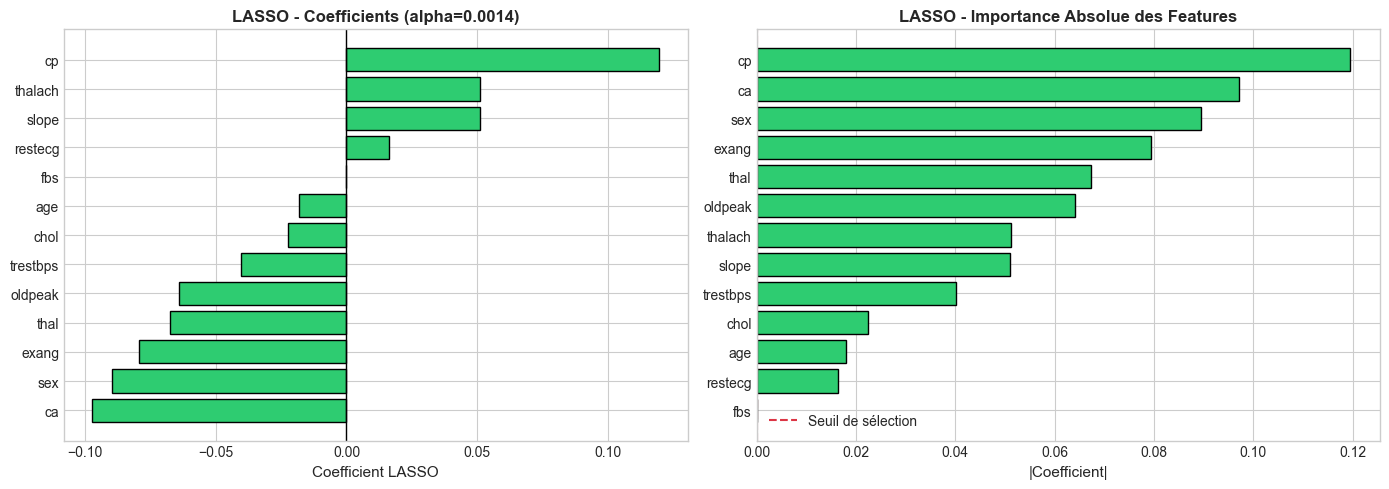

Figure sauvegardée : lasso_results.png


In [25]:
# ============================================================================
# VISUALISATION LASSO
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Coefficients LASSO
ax1 = axes[0]
coef_sorted = coef_df.sort_values('Coefficient')
colors_lasso = [COLORS['lasso'] if s else '#CCCCCC' for s in coef_sorted['Selected']]
ax1.barh(coef_sorted['Feature'], coef_sorted['Coefficient'], color=colors_lasso, edgecolor='black')
ax1.axvline(x=0, color='black', linewidth=1)
ax1.set_xlabel('Coefficient LASSO', fontsize=11)
ax1.set_title(f'LASSO - Coefficients (alpha={best_alpha:.4f})', fontsize=12, fontweight='bold')

# 2. Importance absolue
ax2 = axes[1]
coef_abs_sorted = coef_df.sort_values('Abs_Coefficient', ascending=True)
colors_abs = [COLORS['lasso'] if s else '#CCCCCC' for s in coef_abs_sorted['Selected']]
ax2.barh(coef_abs_sorted['Feature'], coef_abs_sorted['Abs_Coefficient'], 
         color=colors_abs, edgecolor='black')
ax2.set_xlabel('|Coefficient|', fontsize=11)
ax2.set_title('LASSO - Importance Absolue des Features', fontsize=12, fontweight='bold')

# Ligne de seuil
ax2.axvline(x=1e-5, color=COLORS['danger'], linestyle='--', label='Seuil de sélection')
ax2.legend()

plt.tight_layout()
plt.savefig('images/lasso_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure sauvegardée : lasso_results.png")

---

## 8. Méthode 4 : PCA (Principal Component Analysis)

**Principe :** PCA réduit la dimensionnalité en projetant les données sur des composantes principales qui maximisent la variance.

In [26]:
# ============================================================================
# PCA - PRINCIPAL COMPONENT ANALYSIS
# ============================================================================

print("="*80)
print("MÉTHODE 4 : PCA (Principal Component Analysis)")
print("="*80)

with mlflow.start_run(run_name="PCA_Reduction"):
    
    start_time = time.time()
    
    # PCA complet pour analyse
    pca_full = PCA(random_state=RANDOM_STATE)
    pca_full.fit(X_train_scaled)
    
    # Variance expliquée
    explained_variance = pca_full.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)
    
    # Trouver le nombre de composantes pour 95% de variance
    n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
    
    # PCA avec n_components optimal
    pca = PCA(n_components=n_components_95, random_state=RANDOM_STATE)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    execution_time = time.time() - start_time
    
    # Évaluer
    results, _ = evaluate_features(X_train_pca, X_test_pca, y_train, y_test, "PCA")
    
    # Logger dans MLflow
    mlflow.log_param("method", "PCA")
    mlflow.log_param("n_components", n_components_95)
    mlflow.log_param("variance_threshold", 0.95)
    
    mlflow.log_metric("n_components_selected", n_components_95)
    mlflow.log_metric("total_variance_explained", cumulative_variance[n_components_95-1])
    mlflow.log_metric("train_accuracy", results['train_accuracy'])
    mlflow.log_metric("test_accuracy", results['test_accuracy'])
    mlflow.log_metric("cv_mean_accuracy", results['cv_mean'])
    mlflow.log_metric("cv_std_accuracy", results['cv_std'])
    mlflow.log_metric("execution_time", execution_time)
    
    mlflow.set_tag("dimensionality_reduction", "linear")
    mlflow.set_tag("algorithm", "PCA")
    
    # Sauvegarder
    all_results.append(results)
    selected_features_dict['PCA'] = [f'PC{i+1}' for i in range(n_components_95)]
    transformed_data_dict['PCA'] = {'train': X_train_pca, 'test': X_test_pca}
    
    print(f"\n\u2705 PCA terminé en {execution_time:.2f}s")
    print(f"\nNombre de composantes pour 95% de variance : {n_components_95}")
    print(f"Variance totale expliquée : {cumulative_variance[n_components_95-1]*100:.2f}%")
    
    print(f"\nVariance expliquée par composante :")
    variance_df = pd.DataFrame({
        'Composante': [f'PC{i+1}' for i in range(len(explained_variance))],
        'Variance Expliquée (%)': explained_variance * 100,
        'Variance Cumulée (%)': cumulative_variance * 100
    })
    display(variance_df.round(2))

MÉTHODE 4 : PCA (Principal Component Analysis)

✅ PCA terminé en 0.03s

Nombre de composantes pour 95% de variance : 12
Variance totale expliquée : 97.08%

Variance expliquée par composante :


,Composante,Variance Expliquée (%),Variance Cumulée (%)
0,PC1,21.8300,21.8300
1,PC2,12.0400,33.8700
2,PC3,9.1900,43.0600
3,PC4,9.1000,52.1600
4,PC5,7.5600,59.7200
5,PC6,7.1900,66.9100
6,PC7,6.9000,73.8100
7,PC8,5.9000,79.7100
8,PC9,5.5800,85.2800
9,PC10,4.7500,90.0400


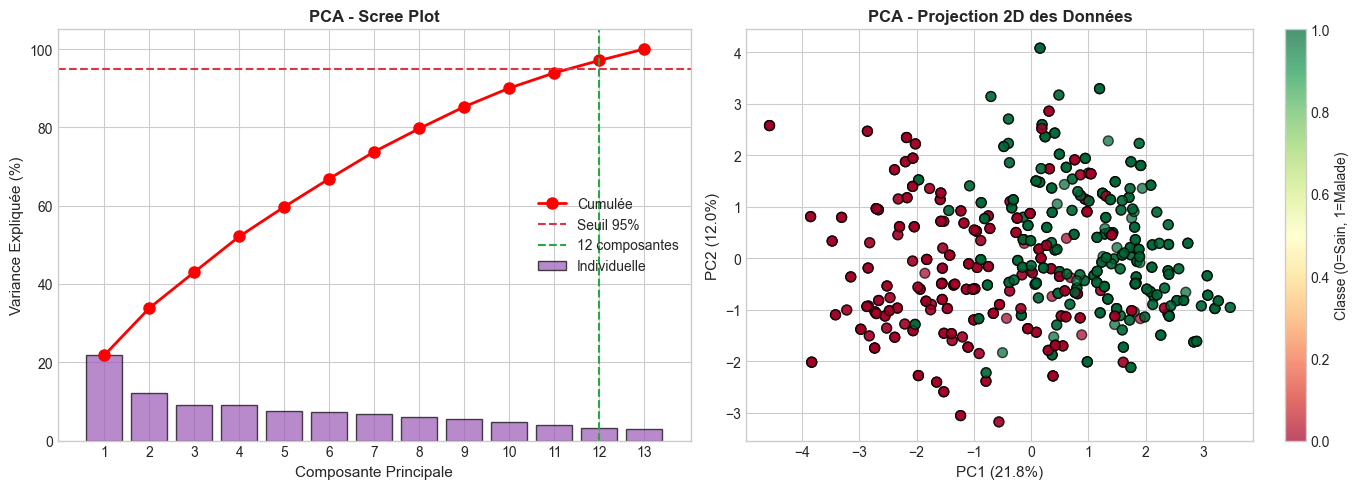

Figure sauvegardée : pca_analysis.png


In [27]:
# ============================================================================
# VISUALISATION PCA - VARIANCE EXPLIQUÉE
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Scree Plot
ax1 = axes[0]
x = range(1, len(explained_variance) + 1)
ax1.bar(x, explained_variance * 100, color=COLORS['pca'], alpha=0.7, edgecolor='black', label='Individuelle')
ax1.plot(x, cumulative_variance * 100, 'ro-', linewidth=2, markersize=8, label='Cumulée')
ax1.axhline(y=95, color=COLORS['danger'], linestyle='--', label='Seuil 95%')
ax1.axvline(x=n_components_95, color=COLORS['success'], linestyle='--', 
            label=f'{n_components_95} composantes')

ax1.set_xlabel('Composante Principale', fontsize=11)
ax1.set_ylabel('Variance Expliquée (%)', fontsize=11)
ax1.set_title('PCA - Scree Plot', fontsize=12, fontweight='bold')
ax1.legend(loc='center right')
ax1.set_xticks(x)

# 2. Projection 2D
ax2 = axes[1]
pca_2d = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca_2d = pca_2d.fit_transform(X_train_scaled)

scatter = ax2.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=y_train, 
                       cmap='RdYlGn', alpha=0.7, edgecolor='black', s=50)
ax2.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)', fontsize=11)
ax2.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)', fontsize=11)
ax2.set_title('PCA - Projection 2D des Données', fontsize=12, fontweight='bold')

# Colorbar
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Classe (0=Sain, 1=Malade)')

plt.tight_layout()
plt.savefig('images/pca_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure sauvegardée : pca_analysis.png")

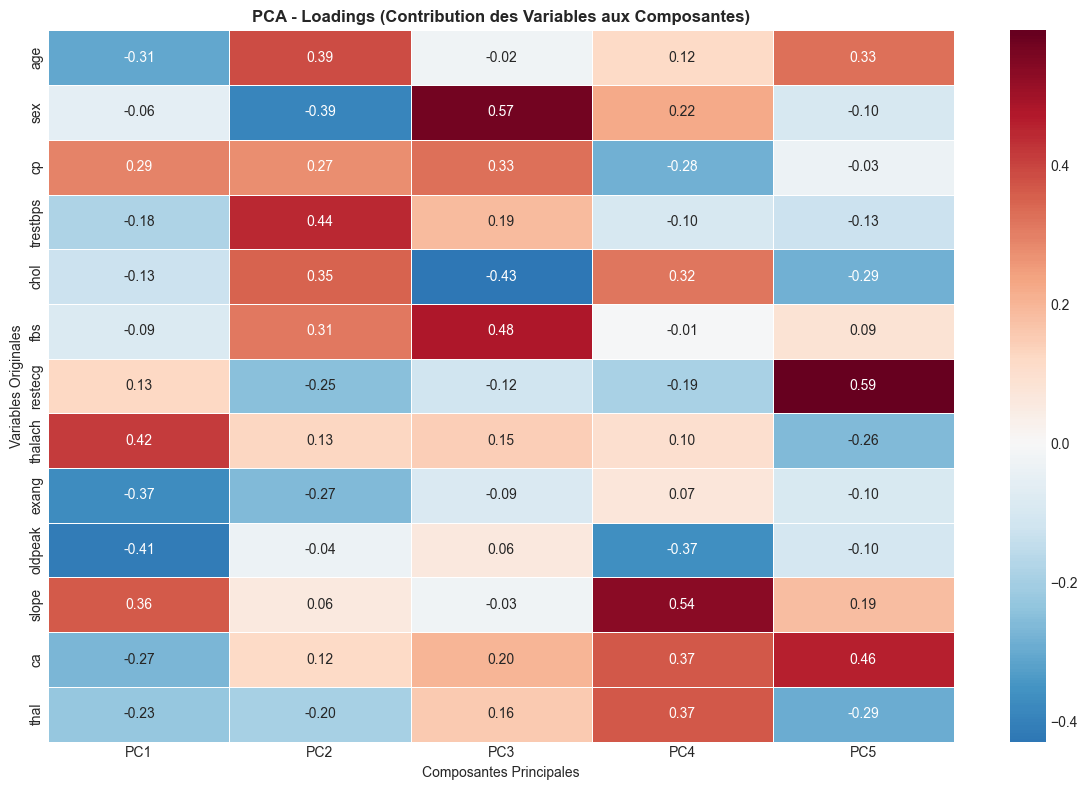

Figure sauvegardée : pca_loadings.png

Loadings PCA (contribution des variables aux 5 premières composantes) :


,PC1,PC2,PC3,PC4,PC5
age,-0.3090,0.3880,-0.0220,0.1160,0.3270
sex,-0.0590,-0.3900,0.5750,0.2240,-0.1000
cp,0.2910,0.2750,0.3260,-0.2830,-0.0340
trestbps,-0.1830,0.4440,0.1880,-0.1000,-0.1260
chol,-0.1270,0.3500,-0.4300,0.3150,-0.2850
fbs,-0.0860,0.3130,0.4810,-0.0060,0.0850
restecg,0.1260,-0.2460,-0.1160,-0.1930,0.5950
thalach,0.4180,0.1270,0.1460,0.0990,-0.2630
exang,-0.3730,-0.2650,-0.0900,0.0710,-0.0970
oldpeak,-0.4140,-0.0350,0.0640,-0.3660,-0.1040


In [28]:
# ============================================================================
# PCA - LOADINGS (Contribution des variables)
# ============================================================================

fig, ax = plt.subplots(figsize=(12, 8))

# Matrice des loadings
loadings = pca_full.components_[:5].T  # Prendre les 5 premières composantes
loadings_df = pd.DataFrame(
    loadings,
    index=feature_names,
    columns=[f'PC{i+1}' for i in range(5)]
)

# Heatmap
sns.heatmap(loadings_df, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            linewidths=0.5, ax=ax)
ax.set_title('PCA - Loadings (Contribution des Variables aux Composantes)', 
             fontsize=12, fontweight='bold')
ax.set_xlabel('Composantes Principales')
ax.set_ylabel('Variables Originales')

plt.tight_layout()
plt.savefig('images/pca_loadings.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure sauvegardée : pca_loadings.png")
print("\nLoadings PCA (contribution des variables aux 5 premières composantes) :")
display(loadings_df.round(3))

---

## 9. Méthode 5 : LDA (Linear Discriminant Analysis)

**Principe :** LDA maximise la séparation entre les classes tout en réduisant la dimensionnalité.

In [29]:
# ============================================================================
# LDA - LINEAR DISCRIMINANT ANALYSIS
# ============================================================================

print("="*80)
print("MÉTHODE 5 : LDA (Linear Discriminant Analysis)")
print("="*80)

with mlflow.start_run(run_name="LDA_Reduction"):
    
    start_time = time.time()
    
    # Pour un problème binaire, LDA produit max 1 composante
    n_classes = len(np.unique(y_train))
    n_components_lda = min(n_classes - 1, len(feature_names))
    
    # Appliquer LDA
    lda = LDA(n_components=n_components_lda)
    X_train_lda = lda.fit_transform(X_train_scaled, y_train)
    X_test_lda = lda.transform(X_test_scaled)
    
    execution_time = time.time() - start_time
    
    # Variance expliquée (ratio de variance entre classes)
    explained_variance_lda = lda.explained_variance_ratio_ if hasattr(lda, 'explained_variance_ratio_') else [1.0]
    
    # Évaluer
    results, _ = evaluate_features(X_train_lda, X_test_lda, y_train, y_test, "LDA")
    
    # Logger dans MLflow
    mlflow.log_param("method", "LDA")
    mlflow.log_param("n_components", n_components_lda)
    mlflow.log_param("n_classes", n_classes)
    
    mlflow.log_metric("n_components_selected", n_components_lda)
    mlflow.log_metric("train_accuracy", results['train_accuracy'])
    mlflow.log_metric("test_accuracy", results['test_accuracy'])
    mlflow.log_metric("cv_mean_accuracy", results['cv_mean'])
    mlflow.log_metric("cv_std_accuracy", results['cv_std'])
    mlflow.log_metric("execution_time", execution_time)
    
    mlflow.set_tag("dimensionality_reduction", "supervised_linear")
    mlflow.set_tag("algorithm", "LDA")
    
    # Sauvegarder
    all_results.append(results)
    selected_features_dict['LDA'] = [f'LD{i+1}' for i in range(n_components_lda)]
    transformed_data_dict['LDA'] = {'train': X_train_lda, 'test': X_test_lda}
    
    print(f"\n\u2705 LDA terminé en {execution_time:.2f}s")
    print(f"\nNombre de composantes LDA : {n_components_lda}")
    print(f"(Maximum pour {n_classes} classes = {n_classes - 1})")
    
    # Coefficients LDA
    print(f"\nCoefficients LDA (scalings) :")
    lda_coef_df = pd.DataFrame({
        'Feature': feature_names,
        'LD1_Coefficient': lda.scalings_[:, 0] if lda.scalings_.ndim > 1 else lda.scalings_
    }).sort_values('LD1_Coefficient', key=abs, ascending=False)
    display(lda_coef_df)

MÉTHODE 5 : LDA (Linear Discriminant Analysis)

✅ LDA terminé en 0.03s

Nombre de composantes LDA : 1
(Maximum pour 2 classes = 1)

Coefficients LDA (scalings) :


,Feature,LD1_Coefficient
2,cp,0.4804
11,ca,-0.3914
1,sex,-0.3643
8,exang,-0.3190
12,thal,-0.2706
9,oldpeak,-0.2553
10,slope,0.2077
7,thalach,0.2050
3,trestbps,-0.1660
4,chol,-0.0944


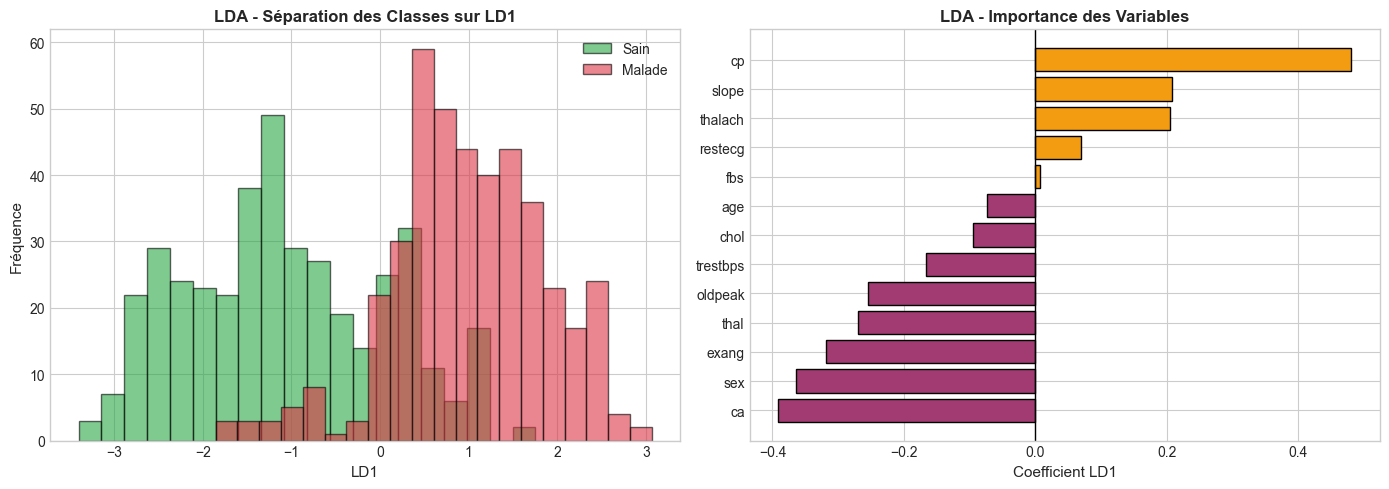

Figure sauvegardée : lda_analysis.png


In [30]:
# ============================================================================
# VISUALISATION LDA
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Distribution des classes sur LD1
ax1 = axes[0]
for target_val, color, label in [(0, COLORS['healthy'], 'Sain'), 
                                  (1, COLORS['disease'], 'Malade')]:
    mask = y_train == target_val
    ax1.hist(X_train_lda[mask, 0], bins=20, alpha=0.6, color=color, 
             label=label, edgecolor='black')

ax1.set_xlabel('LD1', fontsize=11)
ax1.set_ylabel('Fréquence', fontsize=11)
ax1.set_title('LDA - Séparation des Classes sur LD1', fontsize=12, fontweight='bold')
ax1.legend()

# 2. Coefficients LDA
ax2 = axes[1]
lda_coef_sorted = lda_coef_df.sort_values('LD1_Coefficient')
colors_lda = [COLORS['lda'] if c > 0 else COLORS['secondary'] 
              for c in lda_coef_sorted['LD1_Coefficient']]
ax2.barh(lda_coef_sorted['Feature'], lda_coef_sorted['LD1_Coefficient'], 
         color=colors_lda, edgecolor='black')
ax2.axvline(x=0, color='black', linewidth=1)
ax2.set_xlabel('Coefficient LD1', fontsize=11)
ax2.set_title('LDA - Importance des Variables', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('images/lda_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure sauvegardée : lda_analysis.png")

---

## 10. Méthode 6 : t-SNE (t-Distributed Stochastic Neighbor Embedding)

**Principe :** t-SNE est une technique non-linéaire de réduction de dimension, idéale pour la visualisation.

In [34]:
# ============================================================================
# t-SNE - t-DISTRIBUTED STOCHASTIC NEIGHBOR EMBEDDING
# ============================================================================

print("="*80)
print("MÉTHODE 6 : t-SNE (t-Distributed Stochastic Neighbor Embedding)")
print("="*80)

with mlflow.start_run(run_name="tSNE_Reduction"):
    
    start_time = time.time()
    
    # Paramètres t-SNE
    n_components_tsne = 2
    perplexity = 30
    learning_rate = 200
    n_iter = 1000
    
    # Appliquer t-SNE
    tsne = TSNE(
        n_components=n_components_tsne,
        perplexity=perplexity,
        learning_rate=learning_rate,
        max_iter=n_iter,
        random_state=RANDOM_STATE,
        init='pca'
    )
    
    # t-SNE ne peut pas transformer de nouvelles données, donc on l'applique sur tout
    X_all_scaled = np.vstack([X_train_scaled, X_test_scaled])
    y_all = pd.concat([y_train, y_test])
    
    X_tsne = tsne.fit_transform(X_all_scaled)
    
    # Séparer à nouveau
    X_train_tsne = X_tsne[:len(X_train_scaled)]
    X_test_tsne = X_tsne[len(X_train_scaled):]
    
    execution_time = time.time() - start_time
    
    # Évaluer (Note: t-SNE n'est pas conçu pour la classification, mais pour la visualisation)
    results, _ = evaluate_features(X_train_tsne, X_test_tsne, y_train, y_test, "t-SNE")
    
    # KL divergence (mesure de qualité de t-SNE)
    kl_divergence = tsne.kl_divergence_
    
    # Logger dans MLflow
    mlflow.log_param("method", "t-SNE")
    mlflow.log_param("n_components", n_components_tsne)
    mlflow.log_param("perplexity", perplexity)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("n_iter", n_iter)
    
    mlflow.log_metric("n_components_selected", n_components_tsne)
    mlflow.log_metric("kl_divergence", kl_divergence)
    mlflow.log_metric("train_accuracy", results['train_accuracy'])
    mlflow.log_metric("test_accuracy", results['test_accuracy'])
    mlflow.log_metric("cv_mean_accuracy", results['cv_mean'])
    mlflow.log_metric("cv_std_accuracy", results['cv_std'])
    mlflow.log_metric("execution_time", execution_time)
    
    mlflow.set_tag("dimensionality_reduction", "non_linear")
    mlflow.set_tag("algorithm", "t-SNE")
    mlflow.set_tag("note", "Principalement pour visualisation")
    
    # Sauvegarder
    all_results.append(results)
    selected_features_dict['t-SNE'] = [f'tSNE{i+1}' for i in range(n_components_tsne)]
    transformed_data_dict['t-SNE'] = {'train': X_train_tsne, 'test': X_test_tsne, 'all': X_tsne}
    
    print(f"\n✅ t-SNE terminé en {execution_time:.2f}s")
    print(f"\nParamètres :")
    print(f"  - n_components : {n_components_tsne}")
    print(f"  - perplexity : {perplexity}")
    print(f"  - learning_rate : {learning_rate}")
    print(f"  - n_iter : {n_iter}")
    print(f"\nKL Divergence : {kl_divergence:.4f}")
    print("\n⚠️ Note : t-SNE est principalement utilisé pour la visualisation, pas pour la classification.")

MÉTHODE 6 : t-SNE (t-Distributed Stochastic Neighbor Embedding)

✅ t-SNE terminé en 11.16s

Paramètres :
  - n_components : 2
  - perplexity : 30
  - learning_rate : 200
  - n_iter : 1000

KL Divergence : -0.7724

⚠️ Note : t-SNE est principalement utilisé pour la visualisation, pas pour la classification.


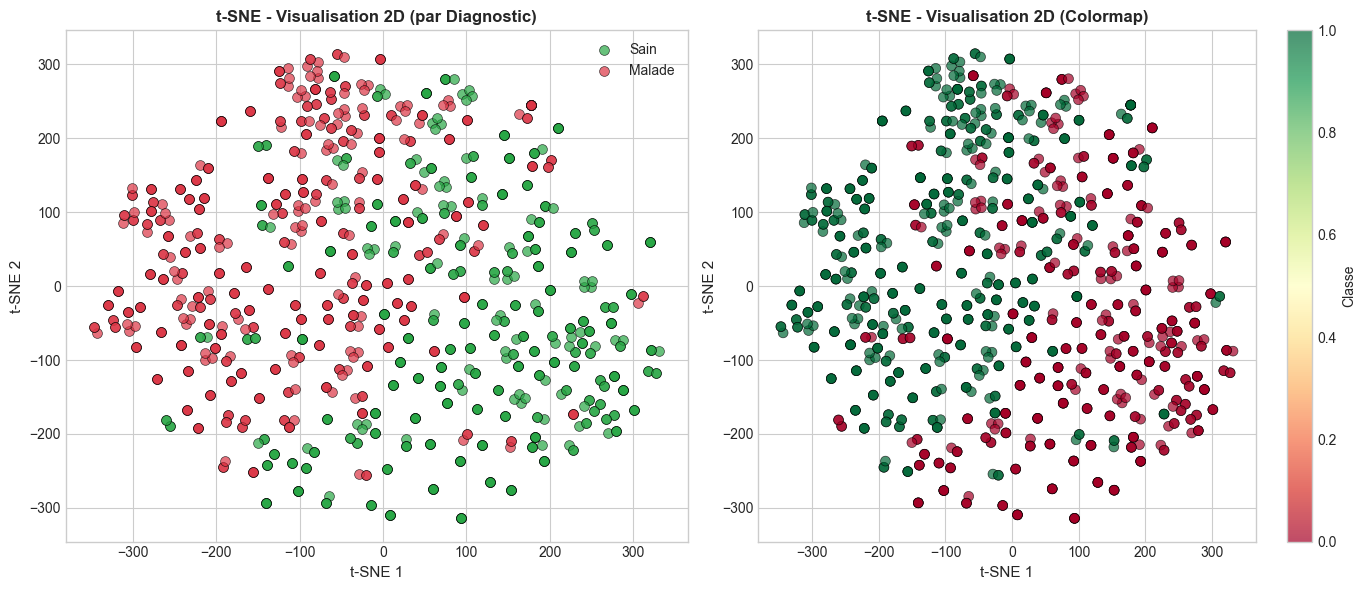

Figure sauvegardée : tsne_visualization.png


In [35]:
# ============================================================================
# VISUALISATION t-SNE
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. t-SNE colorié par classe
ax1 = axes[0]
for target_val, color, label in [(0, COLORS['healthy'], 'Sain'), 
                                  (1, COLORS['disease'], 'Malade')]:
    mask = y_all == target_val
    ax1.scatter(X_tsne[mask, 0], X_tsne[mask, 1], c=color, label=label, 
                alpha=0.7, s=50, edgecolor='black', linewidth=0.5)

ax1.set_xlabel('t-SNE 1', fontsize=11)
ax1.set_ylabel('t-SNE 2', fontsize=11)
ax1.set_title('t-SNE - Visualisation 2D (par Diagnostic)', fontsize=12, fontweight='bold')
ax1.legend()

# 2. t-SNE avec densité
ax2 = axes[1]
scatter = ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_all, 
                       cmap='RdYlGn', alpha=0.7, s=50, edgecolor='black', linewidth=0.5)
ax2.set_xlabel('t-SNE 1', fontsize=11)
ax2.set_ylabel('t-SNE 2', fontsize=11)
ax2.set_title('t-SNE - Visualisation 2D (Colormap)', fontsize=12, fontweight='bold')
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Classe')

plt.tight_layout()
plt.savefig('images/tsne_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure sauvegardée : tsne_visualization.png")


Analyse de l'impact de la perplexity sur t-SNE...


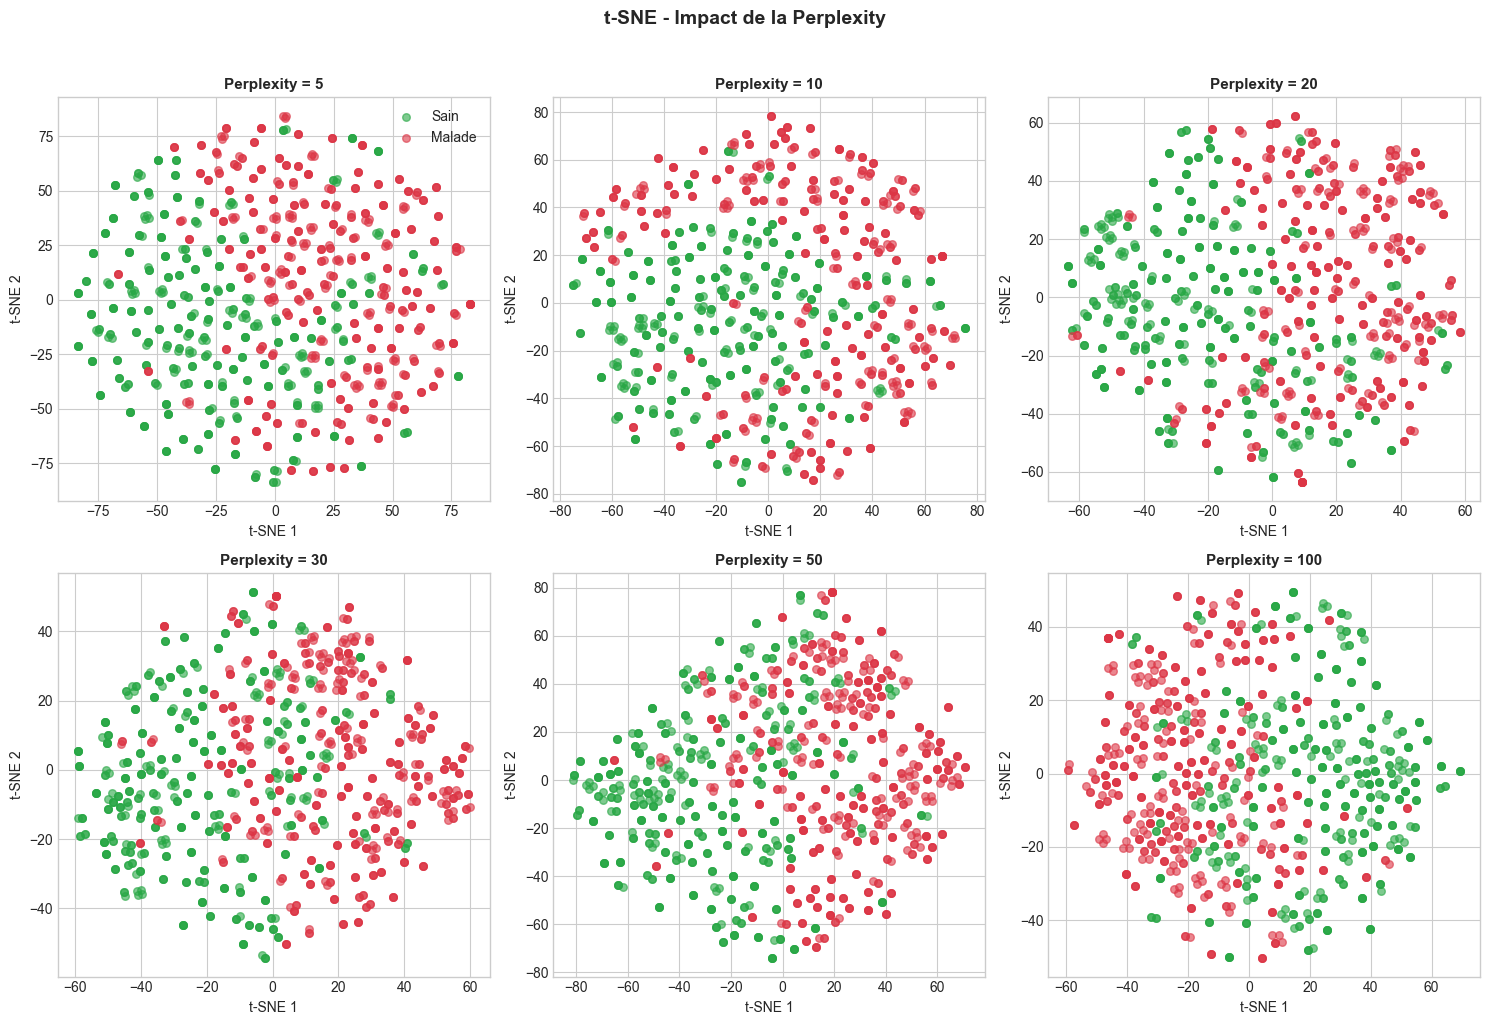

Figure sauvegardée : tsne_perplexity_comparison.png


In [36]:
# ============================================================================
# t-SNE - VARIATION DE PERPLEXITY
# ============================================================================

print("\nAnalyse de l'impact de la perplexity sur t-SNE...")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

perplexities = [5, 10, 20, 30, 50, 100]

for idx, perp in enumerate(perplexities):
    tsne_temp = TSNE(n_components=2, perplexity=perp, random_state=RANDOM_STATE, 
                     max_iter=500, init='pca')
    X_tsne_temp = tsne_temp.fit_transform(X_all_scaled)
    
    ax = axes[idx]
    for target_val, color, label in [(0, COLORS['healthy'], 'Sain'), 
                                      (1, COLORS['disease'], 'Malade')]:
        mask = y_all == target_val
        ax.scatter(X_tsne_temp[mask, 0], X_tsne_temp[mask, 1], c=color, 
                   alpha=0.6, s=30, label=label)
    
    ax.set_title(f'Perplexity = {perp}', fontsize=11, fontweight='bold')
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    if idx == 0:
        ax.legend()

plt.suptitle('t-SNE - Impact de la Perplexity', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('images/tsne_perplexity_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure sauvegardée : tsne_perplexity_comparison.png")

---

## 11. Comparaison des Méthodes

In [37]:
# ============================================================================
# TABLEAU COMPARATIF
# ============================================================================

print("="*80)
print("COMPARAISON DES MÉTHODES DE FEATURE ENGINEERING")
print("="*80)

# Créer le DataFrame de comparaison
comparison_df = pd.DataFrame(all_results)
comparison_df = comparison_df.sort_values('test_accuracy', ascending=False)

# Formater pour l'affichage
comparison_display = comparison_df.copy()
comparison_display['train_accuracy'] = (comparison_display['train_accuracy'] * 100).round(2).astype(str) + '%'
comparison_display['test_accuracy'] = (comparison_display['test_accuracy'] * 100).round(2).astype(str) + '%'
comparison_display['cv_mean'] = (comparison_display['cv_mean'] * 100).round(2).astype(str) + '%'
comparison_display['cv_std'] = (comparison_display['cv_std'] * 100).round(2).astype(str) + '%'
comparison_display['train_time'] = comparison_display['train_time'].round(4).astype(str) + 's'

comparison_display.columns = ['Méthode', 'N Features', 'Train Acc', 'Test Acc', 
                               'CV Mean', 'CV Std', 'Temps']

print("\nPerformances des différentes méthodes (trié par Test Accuracy) :")
display(comparison_display)

COMPARAISON DES MÉTHODES DE FEATURE ENGINEERING

Performances des différentes méthodes (trié par Test Accuracy) :


,Méthode,N Features,Train Acc,Test Acc,CV Mean,CV Std,Temps
0,RFE,7,100.0%,100.0%,98.29%,1.98%,0.2026s
2,LASSO,12,100.0%,100.0%,98.54%,1.26%,0.3111s
4,LDA,1,100.0%,100.0%,98.66%,1.05%,0.2937s
3,PCA,12,100.0%,100.0%,97.93%,2.06%,0.2436s
5,t-SNE,2,100.0%,98.05%,95.73%,1.72%,0.7909s
1,SBS,7,97.56%,97.56%,95.73%,1.28%,0.2732s


In [38]:
# ============================================================================
# FEATURES SÉLECTIONNÉES PAR CHAQUE MÉTHODE
# ============================================================================

print("\nFEATURES SÉLECTIONNÉES PAR CHAQUE MÉTHODE")
print("="*80)

for method, features in selected_features_dict.items():
    print(f"\n{method} ({len(features)} features) :")
    print(f"  {features}")


FEATURES SÉLECTIONNÉES PAR CHAQUE MÉTHODE

RFE (7 features) :
  ['sex', 'cp', 'thalach', 'exang', 'oldpeak', 'ca', 'thal']

SBS (7 features) :
  ['sex', 'cp', 'restecg', 'oldpeak', 'slope', 'ca', 'thal']

LASSO (12 features) :
  ['age', 'sex', 'cp', 'trestbps', 'chol', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']

PCA (12 features) :
  ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12']

LDA (1 features) :
  ['LD1']

t-SNE (2 features) :
  ['tSNE1', 'tSNE2']


In [39]:
# ============================================================================
# ANALYSE DU CONSENSUS
# ============================================================================

print("\nANALYSE DU CONSENSUS (Features de sélection uniquement)")
print("="*80)

# Compter la fréquence de sélection de chaque feature
selection_methods = ['RFE', 'SBS', 'LASSO']
feature_counts = {f: 0 for f in feature_names}

for method in selection_methods:
    if method in selected_features_dict:
        for feature in selected_features_dict[method]:
            if feature in feature_counts:
                feature_counts[feature] += 1

# Créer DataFrame
consensus_df = pd.DataFrame([
    {'Feature': f, 'Nombre de sélections': c, 
     'Pourcentage': f'{c/len(selection_methods)*100:.0f}%'}
    for f, c in feature_counts.items()
]).sort_values('Nombre de sélections', ascending=False)

# Ajouter les méthodes qui ont sélectionné chaque feature
def get_methods(feature):
    methods = []
    for m in selection_methods:
        if m in selected_features_dict and feature in selected_features_dict[m]:
            methods.append(m)
    return ', '.join(methods) if methods else '-'

consensus_df['Sélectionnée par'] = consensus_df['Feature'].apply(get_methods)

print("\nConsensus des méthodes de sélection (RFE, SBS, LASSO) :")
display(consensus_df)

# Features sélectionnées par toutes les méthodes
consensus_features = [f for f, c in feature_counts.items() if c == len(selection_methods)]
print(f"\n\u2705 Features sélectionnées par TOUTES les méthodes ({len(consensus_features)}) :")
print(f"  {consensus_features}")


ANALYSE DU CONSENSUS (Features de sélection uniquement)

Consensus des méthodes de sélection (RFE, SBS, LASSO) :


,Feature,Nombre de sélections,Pourcentage,Sélectionnée par
1,sex,3,100%,"RFE, SBS, LASSO"
2,cp,3,100%,"RFE, SBS, LASSO"
9,oldpeak,3,100%,"RFE, SBS, LASSO"
12,thal,3,100%,"RFE, SBS, LASSO"
11,ca,3,100%,"RFE, SBS, LASSO"
7,thalach,2,67%,"RFE, LASSO"
8,exang,2,67%,"RFE, LASSO"
10,slope,2,67%,"SBS, LASSO"
6,restecg,2,67%,"SBS, LASSO"
4,chol,1,33%,LASSO



✅ Features sélectionnées par TOUTES les méthodes (5) :
  ['sex', 'cp', 'oldpeak', 'ca', 'thal']


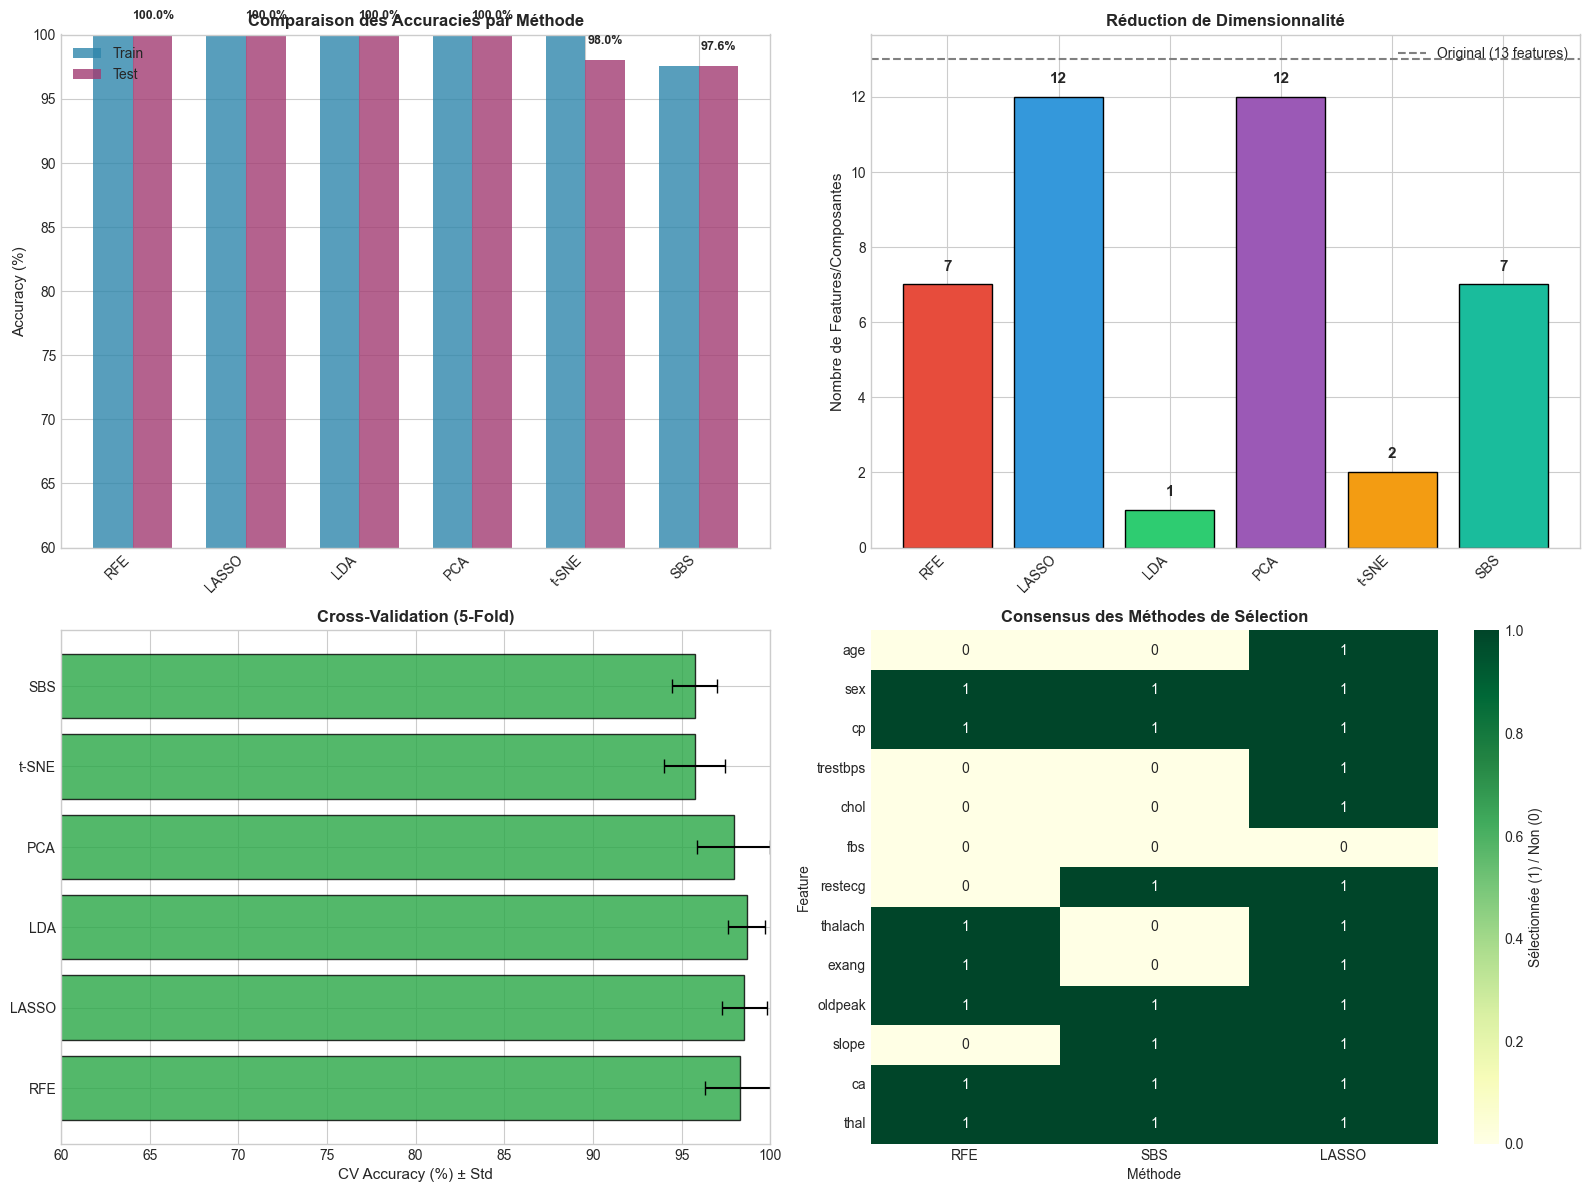

Figure sauvegardée : feature_engineering_comparison.png


In [40]:
# ============================================================================
# VISUALISATION COMPARATIVE
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Comparaison des accuracies
ax1 = axes[0, 0]
methods = comparison_df['method'].tolist()
x = np.arange(len(methods))
width = 0.35

train_acc = comparison_df['train_accuracy'].values * 100
test_acc = comparison_df['test_accuracy'].values * 100

bars1 = ax1.bar(x - width/2, train_acc, width, label='Train', color=COLORS['primary'], alpha=0.8)
bars2 = ax1.bar(x + width/2, test_acc, width, label='Test', color=COLORS['secondary'], alpha=0.8)

ax1.set_ylabel('Accuracy (%)', fontsize=11)
ax1.set_title('Comparaison des Accuracies par Méthode', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(methods, rotation=45, ha='right')
ax1.legend()
ax1.set_ylim(60, 100)

# Ajouter les valeurs
for bar, val in zip(bars2, test_acc):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{val:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 2. Nombre de features
ax2 = axes[0, 1]
n_features = comparison_df['n_features'].values
colors_feat = [COLORS['rfe'], COLORS['sbs'], COLORS['lasso'], 
               COLORS['pca'], COLORS['lda'], COLORS['tsne']]
bars = ax2.bar(methods, n_features, color=colors_feat[:len(methods)], edgecolor='black')
ax2.axhline(y=13, color='gray', linestyle='--', label='Original (13 features)')
ax2.set_ylabel('Nombre de Features/Composantes', fontsize=11)
ax2.set_title('Réduction de Dimensionnalité', fontsize=12, fontweight='bold')
ax2.set_xticklabels(methods, rotation=45, ha='right')
ax2.legend()

for bar, val in zip(bars, n_features):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, 
             str(val), ha='center', va='bottom', fontsize=11, fontweight='bold')

# 3. Cross-validation scores
ax3 = axes[1, 0]
cv_means = comparison_df['cv_mean'].values * 100
cv_stds = comparison_df['cv_std'].values * 100

ax3.barh(methods, cv_means, xerr=cv_stds, color=COLORS['success'], 
         alpha=0.8, edgecolor='black', capsize=5)
ax3.set_xlabel('CV Accuracy (%) \u00b1 Std', fontsize=11)
ax3.set_title('Cross-Validation (5-Fold)', fontsize=12, fontweight='bold')
ax3.set_xlim(60, 100)

# 4. Consensus heatmap
ax4 = axes[1, 1]

# Créer matrice de sélection
selection_matrix = pd.DataFrame(index=feature_names, columns=selection_methods)
for method in selection_methods:
    for feature in feature_names:
        selection_matrix.loc[feature, method] = 1 if feature in selected_features_dict.get(method, []) else 0

selection_matrix = selection_matrix.astype(int)

sns.heatmap(selection_matrix, annot=True, fmt='d', cmap='YlGn', 
            cbar_kws={'label': 'Sélectionnée (1) / Non (0)'}, ax=ax4)
ax4.set_title('Consensus des Méthodes de Sélection', fontsize=12, fontweight='bold')
ax4.set_xlabel('Méthode')
ax4.set_ylabel('Feature')

plt.tight_layout()
plt.savefig('images/feature_engineering_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure sauvegardée : feature_engineering_comparison.png")

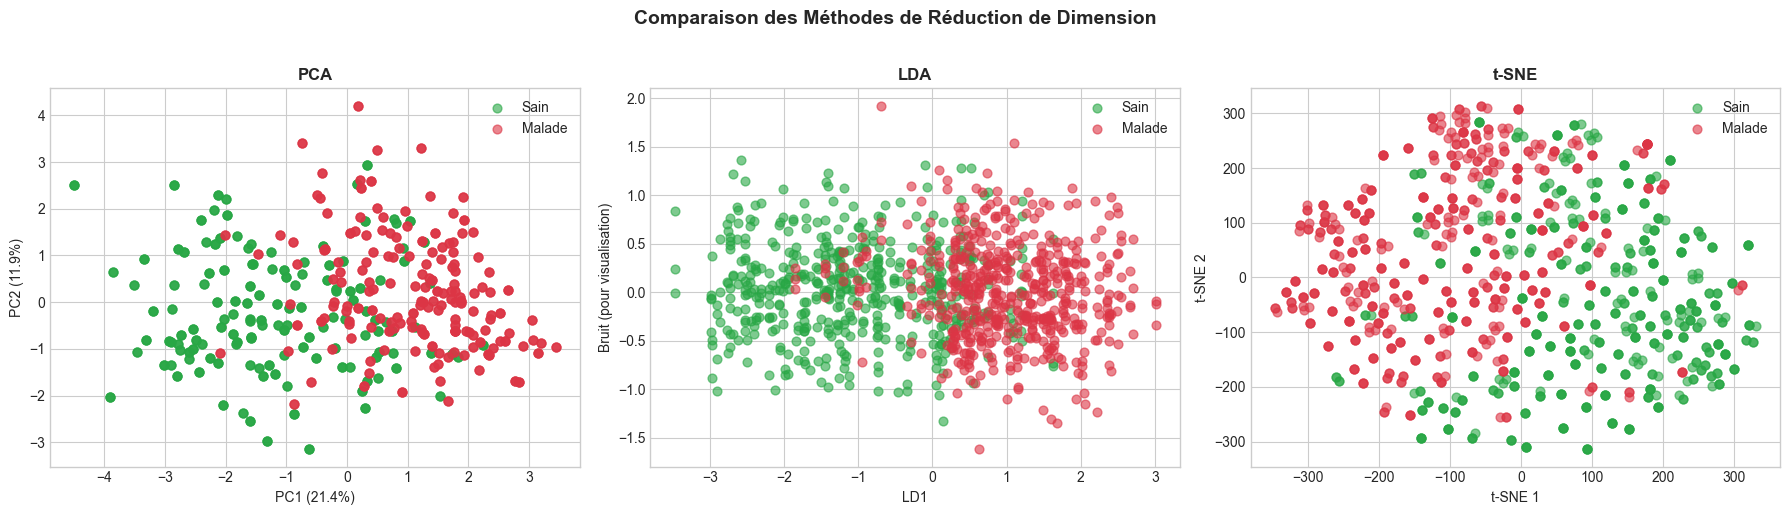

Figure sauvegardée : dimension_reduction_comparison.png


In [41]:
# ============================================================================
# COMPARAISON PCA vs LDA vs t-SNE
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Données pour la visualisation
y_colors = y_all.map({0: COLORS['healthy'], 1: COLORS['disease']})

# 1. PCA
ax1 = axes[0]
pca_2d = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca_2d_all = pca_2d.fit_transform(np.vstack([X_train_scaled, X_test_scaled]))
for target_val, color, label in [(0, COLORS['healthy'], 'Sain'), (1, COLORS['disease'], 'Malade')]:
    mask = y_all == target_val
    ax1.scatter(X_pca_2d_all[mask, 0], X_pca_2d_all[mask, 1], c=color, label=label, alpha=0.6, s=40)
ax1.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)')
ax1.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)')
ax1.set_title('PCA', fontsize=12, fontweight='bold')
ax1.legend()

# 2. LDA (1D, donc on crée un axe artificiel)
ax2 = axes[1]
lda_2d = LDA(n_components=1)
X_lda_all = lda_2d.fit_transform(np.vstack([X_train_scaled, X_test_scaled]), y_all)
# Créer un deuxième axe avec du bruit pour la visualisation
noise = np.random.normal(0, 0.5, size=X_lda_all.shape[0])
for target_val, color, label in [(0, COLORS['healthy'], 'Sain'), (1, COLORS['disease'], 'Malade')]:
    mask = y_all == target_val
    ax2.scatter(X_lda_all[mask, 0], noise[mask], c=color, label=label, alpha=0.6, s=40)
ax2.set_xlabel('LD1')
ax2.set_ylabel('Bruit (pour visualisation)')
ax2.set_title('LDA', fontsize=12, fontweight='bold')
ax2.legend()

# 3. t-SNE
ax3 = axes[2]
for target_val, color, label in [(0, COLORS['healthy'], 'Sain'), (1, COLORS['disease'], 'Malade')]:
    mask = y_all == target_val
    ax3.scatter(X_tsne[mask, 0], X_tsne[mask, 1], c=color, label=label, alpha=0.6, s=40)
ax3.set_xlabel('t-SNE 1')
ax3.set_ylabel('t-SNE 2')
ax3.set_title('t-SNE', fontsize=12, fontweight='bold')
ax3.legend()

plt.suptitle('Comparaison des Méthodes de Réduction de Dimension', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('images/dimension_reduction_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure sauvegardée : dimension_reduction_comparison.png")

---

## 12. Sauvegarde des Résultats et Données Transformées

In [42]:
# ============================================================================
# SAUVEGARDE DES DONNÉES TRANSFORMÉES
# ============================================================================

import os

# Créer le dossier pour les données transformées
os.makedirs('data_transformed', exist_ok=True)

# Sauvegarder les données transformées pour chaque méthode
for method, data in transformed_data_dict.items():
    # Train
    train_df = pd.DataFrame(data['train'], 
                            columns=selected_features_dict[method] if method in ['RFE', 'SBS', 'LASSO'] 
                            else [f'{method}_{i+1}' for i in range(data['train'].shape[1])])
    train_df['target'] = y_train.values
    train_df.to_csv(f'data_transformed/{method.lower()}_train.csv', index=False)
    
    # Test
    test_df = pd.DataFrame(data['test'],
                           columns=selected_features_dict[method] if method in ['RFE', 'SBS', 'LASSO']
                           else [f'{method}_{i+1}' for i in range(data['test'].shape[1])])
    test_df['target'] = y_test.values
    test_df.to_csv(f'data_transformed/{method.lower()}_test.csv', index=False)
    
    print(f"\u2705 {method} : Train ({train_df.shape}) et Test ({test_df.shape}) sauvegardés")

print("\nDonnées transformées sauvegardées dans le dossier 'data_transformed/'")

✅ RFE : Train ((820, 8)) et Test ((205, 8)) sauvegardés
✅ SBS : Train ((820, 8)) et Test ((205, 8)) sauvegardés
✅ LASSO : Train ((820, 13)) et Test ((205, 13)) sauvegardés
✅ PCA : Train ((820, 13)) et Test ((205, 13)) sauvegardés
✅ LDA : Train ((820, 2)) et Test ((205, 2)) sauvegardés
✅ t-SNE : Train ((820, 3)) et Test ((205, 3)) sauvegardés

Données transformées sauvegardées dans le dossier 'data_transformed/'


In [43]:
# ============================================================================
# SAUVEGARDE DU RÉSUMÉ DES RÉSULTATS
# ============================================================================

# Sauvegarder le tableau comparatif
comparison_df.to_csv('feature_engineering_results.csv', index=False)
print("Résultats sauvegardés : feature_engineering_results.csv")

# Sauvegarder le consensus
consensus_df.to_csv('feature_selection_consensus.csv', index=False)
print("Consensus sauvegardé : feature_selection_consensus.csv")

# Sauvegarder les features sélectionnées
with open('selected_features.txt', 'w') as f:
    f.write("FEATURES SÉLECTIONNÉES PAR MÉTHODE\n")
    f.write("="*50 + "\n\n")
    for method, features in selected_features_dict.items():
        f.write(f"{method} ({len(features)}) :\n")
        f.write(f"  {features}\n\n")
    f.write("\nFEATURES CONSENSUS (sélectionnées par toutes les méthodes) :\n")
    f.write(f"  {consensus_features}\n")

print("Features sauvegardées : selected_features.txt")

Résultats sauvegardés : feature_engineering_results.csv
Consensus sauvegardé : feature_selection_consensus.csv
Features sauvegardées : selected_features.txt
